# Reinforcement Learning on 2048
Created 25.06.2025

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipyevents import Event

In [2]:
sys.path.insert(1, str(Path("..")))
import andreas2048
from andreas2048.game import *

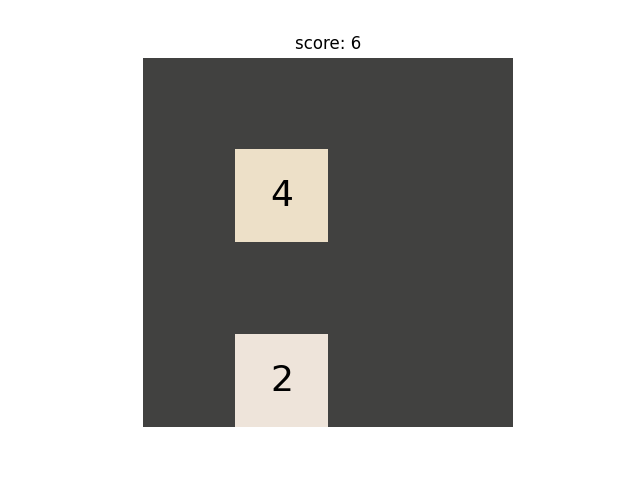

In [6]:
%matplotlib widget

game = andreas2048.Game()

def on_press(e):
    if not game.alive:
        return
    match e.key:
        case "left":
            r = game.try_move(Action.LEFT)
        case "right":
            r = game.try_move(Action.RIGHT)
        case "up":
            r = game.try_move(Action.UP)
        case "down":
            r = game.try_move(Action.DOWN)
        case _:
            r = False
    ax.clear()
    game.plot_on_axis(ax)
    fig.canvas.draw()

fig, ax = plt.subplots()
fig.canvas.mpl_connect('key_press_event', on_press)
game.plot_on_axis(ax)
plt.show()

In [7]:
game.alive

False

In [ ]:
game = andreas2048.Game()

def render():
    ax = plt.subplot()
    game.plot_on_axis(ax)
    plt.show()

True